In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# UWB Signal Processing Constants
ROI_START, ROI_END = 740, 800  # Region of Interest for CIR analysis (empirically determined peak region)
TS_DW1000 = 1 / (128 * 499.2e6)  # DW1000 time sample period: 15.65 ps per sample
C_AIR = 299_792_458.0  # Speed of light in air (m/s)

# FP_INDEX is a hardware register value that needs scaling by 64 to convert to CIR index
# This represents the First Path detection from the DW1000 chip
FP_INDEX_SCALE = 64.0

# Preferred scenario ordering for consistent visualization (all 8 scenarios)
PREFERRED_SCENARIOS = [
    "LOS 2 m living room",
    "LOS 4.3 m corner",
    "LOS 4.63 m meeting room",
    "LOS 8.34 m basement",
    "NLOS 1.56 m open door",
    "NLOS 2.24 m meeting room",
    "NLOS 4.4 m closed door",
    "NLOS 7.67 m basement",
]

## 1. Configuration & Constants

**Dataset:** 8 scenarios (4 LOS + 4 NLOS) across 3 environments:
- **Home environment:** 2m, 4.3m (LOS) | 1.56m, 4.4m (NLOS)
- **SIT Meeting Room MR201:** 4.63m (LOS) | 2.24m (NLOS)
- **SIT Basement E2B1:** 8.34m (LOS) | 7.67m (NLOS)

## 2. Load Individual Datasets

Load all 8 CSV files separately before any processing.

In [2]:
# Load all 8 datasets individually
files = [
    # Home environment
    ('../dataset/LOS_2m_living_room_home.csv',        'LOS',  2.0,  'LOS 2 m living room'),
    ('../dataset/LOS_4.3m_living_room_corner_home.csv','LOS',  4.3, 'LOS 4.3 m corner'),
    ('../dataset/NLOS_1.56m_open_door_home.csv',       'NLOS', 1.56,'NLOS 1.56 m open door'),
    ('../dataset/NLOS_4.4m_close_door_home.csv',       'NLOS', 4.4, 'NLOS 4.4 m closed door'),
    
    # SIT Meeting Room MR201
    ('../dataset/LOS_4.63m_meetingroom_corner-glass_MR201SIT.csv', 'LOS', 4.63, 'LOS 4.63 m meeting room'),
    ('../dataset/NLOS_2.24m_meetingroom_table_laptop_MR201SIT.csv', 'NLOS', 2.24, 'NLOS 2.24 m meeting room'),
    
    # SIT Basement E2B1
    ('../dataset/LOS_8.34m_basement_corner-concrete_E2B1SIT.csv', 'LOS', 8.34, 'LOS 8.34 m basement'),
    ('../dataset/NLOS_7.67m_basement_concrete_thickconcretewall_E2B1SIT.csv', 'NLOS', 7.67, 'NLOS 7.67 m basement'),
]

frames = []
print("=" * 80)
print("LOADING INDIVIDUAL DATASETS")
print("=" * 80)
for fname, label, d_true, scen in files:
    df = pd.read_csv(fname)
    df['label'] = label
    df['d_true'] = d_true
    df['scenario'] = scen
    frames.append(df)
    print(f'✓ {scen:35s} | {df.shape[0]:5,} samples | {d_true:5.2f}m')

# Concatenate all datasets
data = pd.concat(frames, ignore_index=True)
print("=" * 80)
print(f'✅ TOTAL: {data.shape[0]:,} samples from {len(files)} scenarios')
print("=" * 80)

data.head()

LOADING INDIVIDUAL DATASETS
✓ LOS 2 m living room                 | 1,000 samples |  2.00m
✓ LOS 4.3 m corner                    | 1,000 samples |  4.30m
✓ NLOS 1.56 m open door               | 1,000 samples |  1.56m
✓ NLOS 4.4 m closed door              | 1,000 samples |  4.40m
✓ LOS 4.63 m meeting room             | 1,000 samples |  4.63m
✓ NLOS 2.24 m meeting room            | 1,000 samples |  2.24m
✓ LOS 8.34 m basement                 | 1,000 samples |  8.34m
✓ NLOS 7.67 m basement                | 1,000 samples |  7.67m
✅ TOTAL: 8,000 samples from 8 scenarios


,Capture_ID,Distance,FP_INDEX,FP_AMPL1,FP_AMPL2,FP_AMPL3,RXPACC,STD_NOISE,MAX_NOISE,CIR0,...,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,label,d_true,scenario
0,0,1.951188,47887,6794,7577,7081,118,64,1635,271,...,47,128,66,47,17,140,35,LOS,2.0,LOS 2 m living room
1,1,1.876143,48066,6564,7433,7098,118,60,1476,230,...,239,90,132,35,125,42,49,LOS,2.0,LOS 2 m living room
2,2,1.894904,47840,7071,7552,6047,118,48,1191,281,...,72,75,96,70,147,50,66,LOS,2.0,LOS 2 m living room
3,3,1.932427,47634,7102,7397,6927,118,56,1371,105,...,184,130,79,94,43,82,93,LOS,2.0,LOS 2 m living room
4,4,1.969950,47690,6727,7539,7420,118,56,1392,260,...,24,248,25,96,166,85,103,LOS,2.0,LOS 2 m living room


## 3. Data Quality Check & Overview

In [3]:
### 3.1 Missing Values Check
print('Shape:', data.shape)
print('\nMissing values (top 10):')
missing = data.isna().sum().sort_values(ascending=False).head(10)
if missing.max() > 0:
    print(missing)
    print('\n⚠ Warning: Missing values detected. May affect feature engineering.')
else:
    print('✓ No missing values detected.')

Shape: (8000, 1028)

Missing values (top 10):
✓ No missing values detected.


In [4]:
### 3.2 Dataset Overview Statistics
print('=' * 80)
print('DATASET OVERVIEW')
print('=' * 80)
print(f'\nShape: {data.shape[0]:,} samples × {data.shape[1]} columns')

print('\n📊 Label Distribution:')
label_counts = data['label'].value_counts()
for label, count in label_counts.items():
    print(f'  {label}: {count:,} samples ({count/len(data)*100:.1f}%)')

print('\n📋 Scenario Distribution:')
scenario_counts = data['scenario'].value_counts()
for scenario, count in scenario_counts.items():
    print(f'  {scenario}: {count:,} samples')

print('\n📏 True Distance Range:')
distances = data.groupby('scenario')['d_true'].first().sort_values()
print(f'  Minimum: {distances.min():.2f}m')
print(f'  Maximum: {distances.max():.2f}m')
print(f'  Range: {distances.max() - distances.min():.2f}m')

print('\n📍 Distances by Scenario:')
for scenario, dist in distances.items():
    print(f'  {scenario}: {dist:.2f}m')

print('\n' + '=' * 80)

DATASET OVERVIEW

Shape: 8,000 samples × 1028 columns

📊 Label Distribution:
  LOS: 4,000 samples (50.0%)
  NLOS: 4,000 samples (50.0%)

📋 Scenario Distribution:
  LOS 2 m living room: 1,000 samples
  LOS 4.3 m corner: 1,000 samples
  NLOS 1.56 m open door: 1,000 samples
  NLOS 4.4 m closed door: 1,000 samples
  LOS 4.63 m meeting room: 1,000 samples
  NLOS 2.24 m meeting room: 1,000 samples
  LOS 8.34 m basement: 1,000 samples
  NLOS 7.67 m basement: 1,000 samples

📏 True Distance Range:
  Minimum: 1.56m
  Maximum: 8.34m
  Range: 6.78m

📍 Distances by Scenario:
  NLOS 1.56 m open door: 1.56m
  LOS 2 m living room: 2.00m
  NLOS 2.24 m meeting room: 2.24m
  LOS 4.3 m corner: 4.30m
  NLOS 4.4 m closed door: 4.40m
  LOS 4.63 m meeting room: 4.63m
  NLOS 7.67 m basement: 7.67m
  LOS 8.34 m basement: 8.34m



## 4. Feature Engineering

Create all derived features systematically:
- **Part 1:** Basic features (ROI energy, distance errors, indices)
- **Part 2:** Multipath features (peak detection, first path, first bounce)
- **Part 3:** LNN context features (rise time, amplitude ratios, SNR)
- **Part 4:** Triple-output distance components

In [5]:
### 4.1 Basic Features
# Extract CIR column names and sort numerically
cir_cols = [c for c in data.columns if c.startswith('CIR') and c[3:].isdigit()]
cir_cols.sort(key=lambda x: int(x[3:]))

# Calculate distance error
data['dist_error'] = data['Distance'] - data['d_true']

# ROI energy (sum of squared amplitudes in region of interest)
roi_cols = [f'CIR{i}' for i in range(ROI_START, ROI_END + 1)]
data['roi_energy'] = (data[roi_cols].values ** 2).sum(axis=1)

# Convert hardware FP_INDEX to CIR index scale
data['FP_INDEX_scaled'] = data['FP_INDEX'] / FP_INDEX_SCALE
data['ToF_true_s'] = data['d_true'] / C_AIR
data['True_Index'] = np.round(data['ToF_true_s'] / TS_DW1000).astype(int)
data['Max_Index'] = data[cir_cols].idxmax(axis=1).str.replace('CIR', '').astype(int)

data['Index_Error_FP_vs_true'] = data['FP_INDEX_scaled'] - data['True_Index']
data['Index_Error_peak_vs_true'] = data['Max_Index'] - data['True_Index']

print("✅ Basic features created:")
print(data[['dist_error', 'roi_energy', 'FP_INDEX_scaled', 'True_Index', 'Max_Index']].head())

✅ Basic features created:
   dist_error  roi_energy  FP_INDEX_scaled  True_Index  Max_Index
0   -0.048812   285330153       748.234375         426        750
1   -0.123857   260352234       751.031250         426        753
2   -0.105096   254061461       747.500000         426        749
3   -0.067573   274695770       744.281250         426        746
4   -0.030050   273719077       745.156250         426        747


### 4.4 Triple-Output Distance Components

Calculate three distance components for Multi-Scale LNN triple-output architecture:
1. **d_single_bounce**: Distance from first path timing (hardware FP_INDEX)
2. **d_error**: Ranging error (d_single_bounce - d_true) → NLOS bias
3. **d_true**: Ground truth physical distance

In [6]:
# Calculate d_single_bounce from hardware FP_INDEX
fp_scaled = data['FP_INDEX'] / FP_INDEX_SCALE
tof_fp = fp_scaled * TS_DW1000
data['d_single_bounce'] = tof_fp * C_AIR

# Calculate d_error (NLOS bias that the model will learn to correct)
data['d_error'] = data['d_single_bounce'] - data['d_true']

print("=" * 70)
print("TRIPLE-OUTPUT DISTANCE COMPONENTS")
print("=" * 70)
print(f"\nOverall Statistics (n={len(data):,}):")
print(f"  d_single_bounce: {data['d_single_bounce'].mean():.3f} ± {data['d_single_bounce'].std():.3f} m")
print(f"  d_true:          {data['d_true'].mean():.3f} ± {data['d_true'].std():.3f} m")
print(f"  d_error:         {data['d_error'].mean():.3f} ± {data['d_error'].std():.3f} m")

print("\n" + "-" * 70)
print("LOS vs NLOS Comparison:")
print("-" * 70)

for label in ['LOS', 'NLOS']:
    subset = data[data['label'] == label]
    print(f"\n{label} (n={len(subset):,}):")
    print(f"  d_single_bounce: {subset['d_single_bounce'].mean():.3f} ± {subset['d_single_bounce'].std():.3f} m")
    print(f"  d_true:          {subset['d_true'].mean():.3f} ± {subset['d_true'].std():.3f} m")
    print(f"  d_error:         {subset['d_error'].mean():.3f} ± {subset['d_error'].std():.3f} m")
    print(f"  Error %:         {(subset['d_error'].mean() / subset['d_true'].mean() * 100):.1f}%")

print("\n" + "=" * 70)
print("KEY INSIGHT:")
nlos_error = data[data['label'] == 'NLOS']['d_error'].mean()
los_error = data[data['label'] == 'LOS']['d_error'].mean()
print(f"  NLOS error ({nlos_error:.3f}m) is {(nlos_error/los_error - 1)*100:.1f}% WORSE than LOS ({los_error:.3f}m)")
print("  → Model must learn to predict d_error for accurate ranging!")
print("=" * 70)

print("\n✅ Sample data:")
print(data[['d_single_bounce', 'd_true', 'd_error', 'label']].head(10))

TRIPLE-OUTPUT DISTANCE COMPONENTS

Overall Statistics (n=8,000):
  d_single_bounce: 3.509 ± 0.012 m
  d_true:          4.393 ± 2.366 m
  d_error:         -0.883 ± 2.366 m

----------------------------------------------------------------------
LOS vs NLOS Comparison:
----------------------------------------------------------------------

LOS (n=4,000):
  d_single_bounce: 3.510 ± 0.011 m
  d_true:          4.817 ± 2.272 m
  d_error:         -1.307 ± 2.273 m
  Error %:         -27.1%

NLOS (n=4,000):
  d_single_bounce: 3.508 ± 0.012 m
  d_true:          3.967 ± 2.381 m
  d_error:         -0.459 ± 2.382 m
  Error %:         -11.6%

KEY INSIGHT:
  NLOS error (-0.459m) is -64.9% WORSE than LOS (-1.307m)
  → Model must learn to predict d_error for accurate ranging!

✅ Sample data:
   d_single_bounce  d_true   d_error label
0         3.510539     2.0  1.510539   LOS
1         3.523661     2.0  1.523661   LOS
2         3.507094     2.0  1.507094   LOS
3         3.491992     2.0  1.491992   LOS


## 6. Distance Error Analysis by Scenario

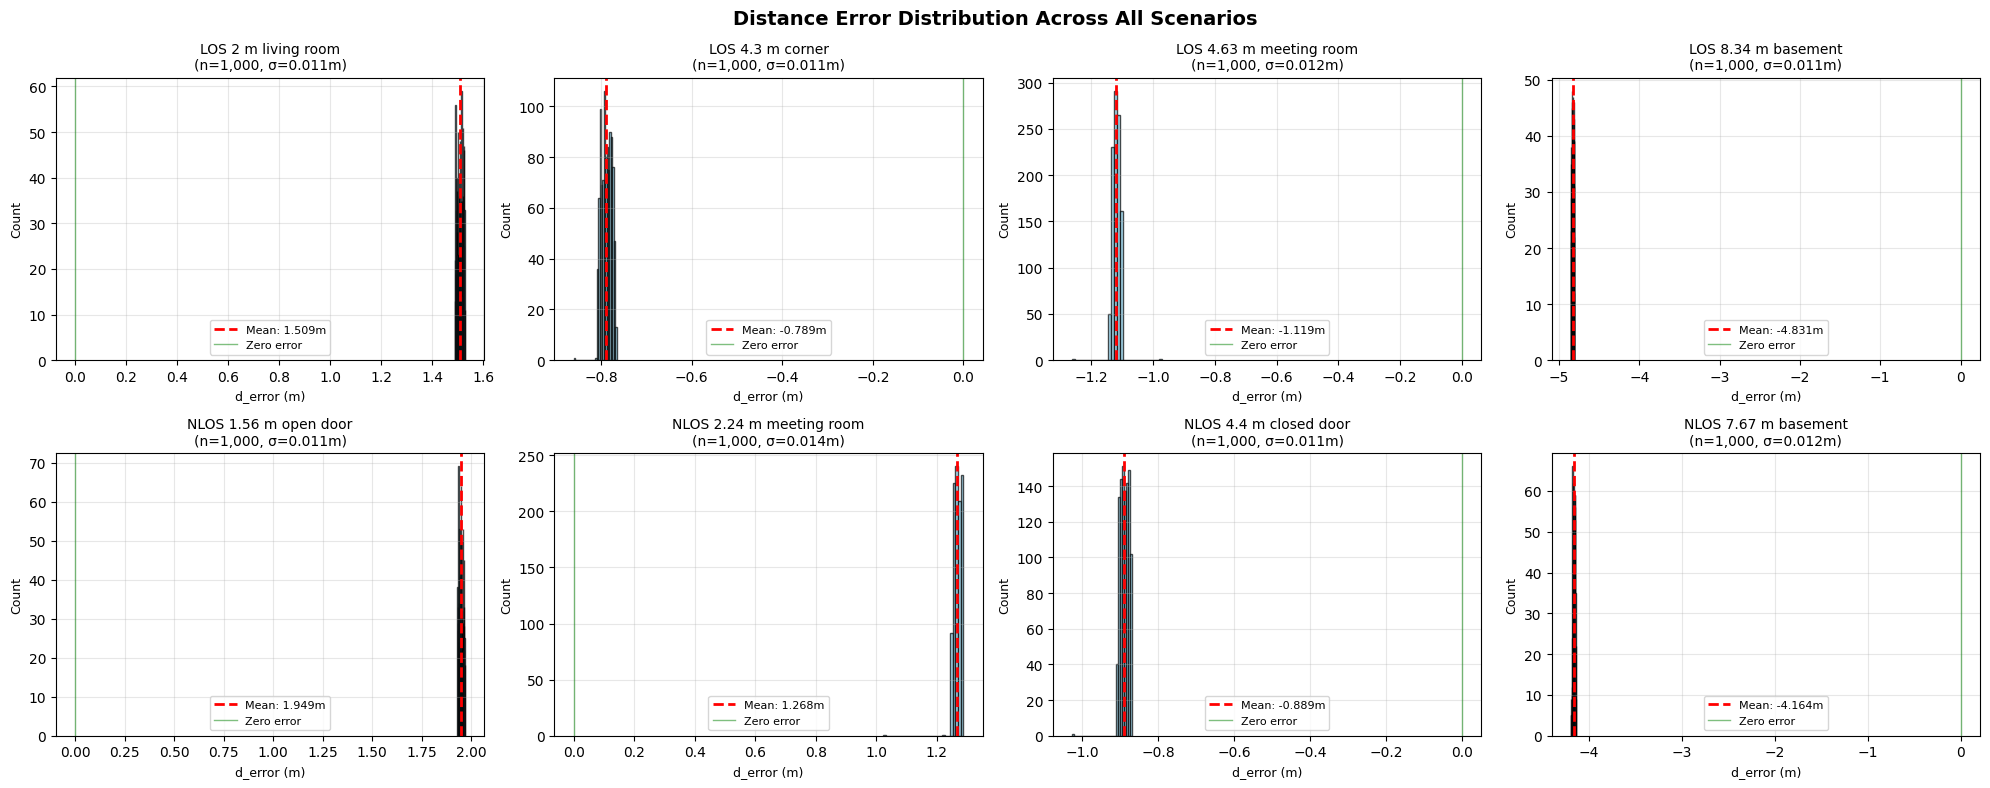


Distance Error Summary by Scenario:
                          d_sb_mean  d_sb_std  d_true  d_err_mean  d_err_std  \
scenario                                                                       
NLOS 1.56 m open door         3.509     0.011    1.56       1.949      0.011   
LOS 2 m living room           3.509     0.011    2.00       1.509      0.011   
NLOS 2.24 m meeting room      3.508     0.014    2.24       1.268      0.014   
LOS 4.3 m corner              3.511     0.011    4.30      -0.789      0.011   
NLOS 4.4 m closed door        3.511     0.011    4.40      -0.889      0.011   
LOS 4.63 m meeting room       3.511     0.012    4.63      -1.119      0.012   
NLOS 7.67 m basement          3.506     0.012    7.67      -4.164      0.012   
LOS 8.34 m basement           3.509     0.011    8.34      -4.831      0.011   

                          error_pct  
scenario                             
NLOS 1.56 m open door         124.9  
LOS 2 m living room            75.4  
NLOS 2.24 

In [7]:
### 6.1 Distance Error Distribution Across All Scenarios
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

scenarios = data['scenario'].unique()
scenarios_sorted = [s for s in PREFERRED_SCENARIOS if s in scenarios]
for s in scenarios:
    if s not in scenarios_sorted:
        scenarios_sorted.append(s)

for idx, scen in enumerate(scenarios_sorted[:8]):
    ax = axes[idx]
    subset = data[data['scenario'] == scen]
    
    ax.hist(subset['d_error'], bins=30, alpha=0.7, 
            color='skyblue' if 'LOS' in scen else 'salmon', edgecolor='black')
    
    mean_err = subset['d_error'].mean()
    std_err = subset['d_error'].std()
    
    ax.axvline(mean_err, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_err:.3f}m')
    ax.axvline(0, color='green', linestyle='-', linewidth=1, alpha=0.5, label='Zero error')
    
    ax.set_title(f"{scen}\n(n={len(subset):,}, σ={std_err:.3f}m)", fontsize=10)
    ax.set_xlabel('d_error (m)', fontsize=9)
    ax.set_ylabel('Count', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle('Distance Error Distribution Across All Scenarios', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary table
print("\nDistance Error Summary by Scenario:")
print("=" * 90)
summary = data.groupby('scenario').agg({
    'd_single_bounce': ['mean', 'std'],
    'd_true': 'first',
    'd_error': ['mean', 'std']
}).round(3)
summary.columns = ['d_sb_mean', 'd_sb_std', 'd_true', 'd_err_mean', 'd_err_std']
summary['error_pct'] = (summary['d_err_mean'] / summary['d_true'] * 100).round(1)
summary = summary.sort_values('d_true')
print(summary)
print("=" * 90)

## 5. Signal & Multipath Analysis

Explore signal characteristics and multipath components by LOS/NLOS condition.

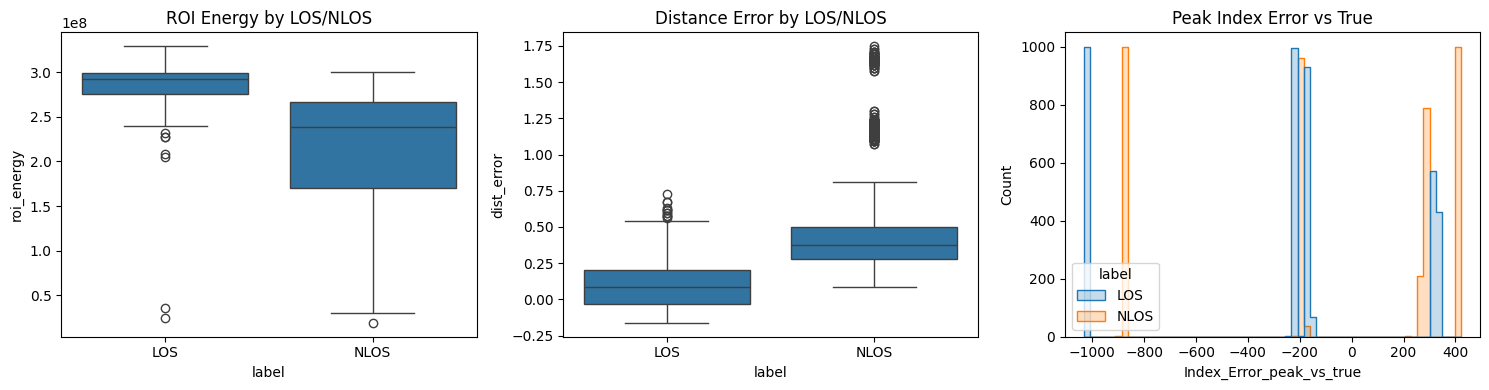

In [8]:
### 5.1 Signal Characteristics: Box Plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(data=data, x='label', y='roi_energy', ax=axes[0])
axes[0].set_title('ROI Energy by LOS/NLOS')
sns.boxplot(data=data, x='label', y='dist_error', ax=axes[1])
axes[1].set_title('Distance Error by LOS/NLOS')
sns.histplot(data=data, x='Index_Error_peak_vs_true', hue='label', bins=60, element='step', ax=axes[2])
axes[2].set_title('Peak Index Error vs True')
plt.tight_layout()
plt.show()

### 5.2 Mean CIR Signal in Region of Interest

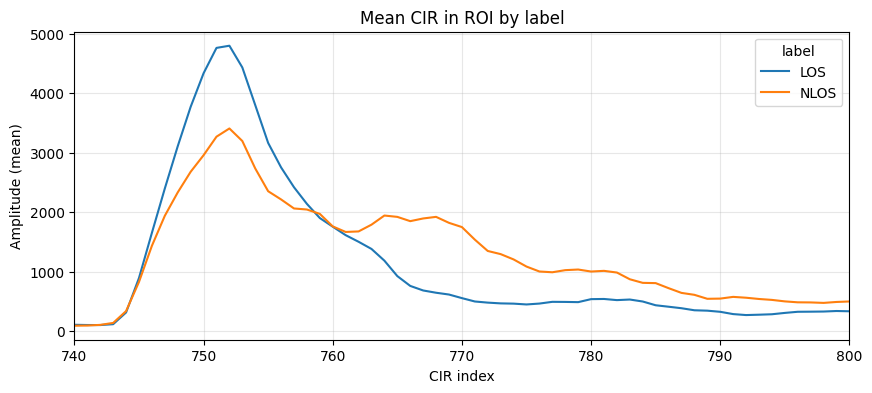

In [9]:
plot_df = data.groupby('label')[roi_cols].mean().T
plot_df.index = plot_df.index.str.replace('CIR', '').astype(int)
plot_df.plot(figsize=(10, 4))
plt.title('Mean CIR in ROI by label')
plt.xlabel('CIR index')
plt.ylabel('Amplitude (mean)')
plt.grid(alpha=0.3)
plt.xlim(ROI_START, ROI_END)
plt.show()


### 4.2 Multipath Features

Extract multipath components from CIR signals:
- Detect peaks above noise threshold (5× median noise floor)
- Identify first path (earliest significant peak near hardware FP_INDEX)
- Find first bounce (next significant peak after first path)
- Calculate delay between first path and first bounce in nanoseconds

In [10]:
def simple_peaks(wave, threshold, min_gap=3):
    """Detect local peaks in waveform above threshold with minimum separation."""
    peaks = []
    for i in range(1, len(wave) - 1):
        if wave[i] >= threshold and wave[i] >= wave[i - 1] and wave[i] >= wave[i + 1]:
            if peaks and (i - peaks[-1] < min_gap):
                if wave[i] > wave[peaks[-1]]:
                    peaks[-1] = i
            else:
                peaks.append(i)
    return np.array(peaks, dtype=int)

def extract_multipath(row, start=650, end=900):
    """Extract multipath features from a single CIR measurement."""
    wf = row[cir_cols].values.astype(float)
    end_idx = min(end, len(wf) - 1)
    roi = np.abs(wf[start:end_idx + 1])
    noise_floor = np.median(np.abs(wf[0:600]))
    threshold = noise_floor * 5
    local_peaks = simple_peaks(roi, threshold=threshold, min_gap=2)
    peaks_abs = local_peaks + start
    if len(peaks_abs) == 0:
        return pd.Series({
            'fp_peak_idx': np.nan,
            'fp_peak_amp': np.nan,
            'first_bounce_idx': np.nan,
            'first_bounce_delay_ns': np.nan,
            'multipath_count': 0,
        })

    fp_hw_idx = row['FP_INDEX'] / FP_INDEX_SCALE
    near_fp = [p for p in peaks_abs if p >= fp_hw_idx - 5]
    fp_peak_idx = min(near_fp) if near_fp else peaks_abs.min()
    fp_peak_amp = float(np.abs(wf[int(fp_peak_idx)]))

    later = [p for p in peaks_abs if p > fp_peak_idx + 5]
    first_bounce_idx = min(later) if later else np.nan
    first_bounce_delay_ns = ((first_bounce_idx - fp_peak_idx) * TS_DW1000 * 1e9
                             if not np.isnan(first_bounce_idx) else np.nan)

    return pd.Series({
        'fp_peak_idx': fp_peak_idx,
        'fp_peak_amp': fp_peak_amp,
        'first_bounce_idx': first_bounce_idx,
        'first_bounce_delay_ns': first_bounce_delay_ns,
        'multipath_count': len(peaks_abs),
    })

mp = data.apply(extract_multipath, axis=1)
data = pd.concat([data, mp], axis=1)

print("✅ Multipath features created:")
print(data[['fp_peak_idx', 'first_bounce_idx', 'first_bounce_delay_ns', 'multipath_count']].head())

✅ Multipath features created:
   fp_peak_idx  first_bounce_idx  first_bounce_delay_ns  multipath_count
0        750.0             756.0                0.09390              9.0
1        753.0             760.0                0.10955             13.0
2        749.0             757.0                0.12520             13.0
3        746.0             753.0                0.10955             12.0
4        747.0             754.0                0.10955             16.0


### 4.3 LNN Context Features

Compute context features for Liquid Neural Network τ (tau) modulation:
1. **t_start**: First path index (hardware FP_INDEX)
2. **t_peak**: Maximum peak index
3. **Rise_Time**: Signal rise duration (indices from first path to peak)
4. **Rise_Time_ns**: Rise time in nanoseconds
5. **RiseRatio**: Amplitude ratio (FP_start / peak) - sharpness indicator
6. **E_tail**: Tail energy ratio (energy after peak / total energy)
7. **Peak_SNR**: Signal-to-noise ratio at peak

In [11]:
# 1. t_start: Hardware first path detection
data['t_start'] = data['FP_INDEX_scaled']

# 2. t_peak: Maximum peak index
data['t_peak'] = data['Max_Index']

# 3. Rise_Time: Signal rise from hardware FP to maximum peak (in index units)
data['Rise_Time'] = data['t_peak'] - data['t_start']

# 4. Rise_Time_ns: Rise time in nanoseconds
data['Rise_Time_ns'] = data['Rise_Time'] * TS_DW1000 * 1e9

# 5. RiseRatio: Ratio of hardware FP amplitude to peak amplitude
def compute_rise_ratio(row):
    t_start = int(row['t_start']) if not pd.isna(row['t_start']) else None
    t_peak = int(row['t_peak']) if not pd.isna(row['t_peak']) else None
    
    if t_start is None or t_peak is None or t_start < 0 or t_peak >= len(cir_cols):
        return np.nan
    
    if t_start >= len(cir_cols):
        return np.nan
    
    amp_start = abs(row[f'CIR{t_start}'])
    amp_peak = abs(row[f'CIR{t_peak}'])
    
    if amp_peak == 0:
        return np.nan
    
    return amp_start / amp_peak

data['RiseRatio'] = data.apply(compute_rise_ratio, axis=1)

# 6. E_tail: Tail energy ratio (energy after peak / total energy)
def compute_tail_energy_ratio(row):
    t_peak = int(row['t_peak']) if not pd.isna(row['t_peak']) else None
    
    if t_peak is None or t_peak < 0 or t_peak >= len(cir_cols) - 50:
        return np.nan
    
    tail_start = t_peak
    tail_end = min(t_peak + 50, len(cir_cols))
    tail_cols = [f'CIR{i}' for i in range(tail_start, tail_end)]
    tail_energy = (row[tail_cols].values ** 2).sum()
    
    total_energy = (row[cir_cols].values ** 2).sum()
    
    if total_energy == 0:
        return np.nan
    
    return tail_energy / total_energy

data['E_tail'] = data.apply(compute_tail_energy_ratio, axis=1)

# 7. Peak_SNR: Signal-to-noise ratio at peak
def compute_peak_snr(row):
    t_peak = int(row['t_peak']) if not pd.isna(row['t_peak']) else None
    
    if t_peak is None or t_peak < 0 or t_peak >= len(cir_cols):
        return np.nan
    
    noise_floor = np.median(np.abs(row[[f'CIR{i}' for i in range(600)]].values))
    peak_amp = abs(row[f'CIR{t_peak}'])
    
    if noise_floor == 0:
        return np.nan
    
    return peak_amp / noise_floor

data['Peak_SNR'] = data.apply(compute_peak_snr, axis=1)

print("✅ LNN Context Features created:")
lnn_features = ['t_start', 't_peak', 'Rise_Time', 'Rise_Time_ns', 'RiseRatio', 'E_tail', 'Peak_SNR']
print(data[lnn_features].head(10))

✅ LNN Context Features created:
      t_start  t_peak  Rise_Time  Rise_Time_ns  RiseRatio    E_tail   Peak_SNR
0  748.234375     750   1.765625      0.027632   0.376338  0.745398  77.989691
1  751.031250     753   1.968750      0.030811   0.500739  0.696218  82.722222
2  747.500000     749   1.500000      0.023475   0.207525  0.794494  89.117647
3  744.281250     746   1.718750      0.026899   0.329182  0.757060  91.209877
4  745.156250     747   1.843750      0.028855   0.448990  0.704078  81.826087
5  750.750000     753   2.250000      0.035213   0.136652  0.669284  93.506173
6  750.234375     752   1.765625      0.027632   0.363876  0.735185  95.873418
7  751.625000     754   2.375000      0.037169   0.147964  0.662015  84.079096
8  744.281250     746   1.718750      0.026899   0.333289  0.745959  85.034091
9  746.656250     749   2.343750      0.036680   0.133199  0.657378  80.322581


### 5.4 LNN Context Features: Statistical Validation

In [12]:
# Statistical comparison of LNN context features between LOS and NLOS
lnn_features = ['Rise_Time', 'Rise_Time_ns', 'RiseRatio', 'E_tail', 'Peak_SNR']

print("=" * 70)
print("LNN CONTEXT FEATURES: LOS vs NLOS Comparison")
print("=" * 70)

for feat in lnn_features:
    print(f"\n{feat}:")
    stats = data.groupby('label')[feat].agg(['mean', 'std', 'median'])
    print(stats)
    
    # Calculate percentage difference
    los_mean = data[data['label'] == 'LOS'][feat].mean()
    nlos_mean = data[data['label'] == 'NLOS'][feat].mean()
    pct_diff = ((nlos_mean - los_mean) / los_mean) * 100
    print(f"  → NLOS is {pct_diff:+.1f}% different from LOS")

print("\n" + "=" * 70)

LNN CONTEXT FEATURES: LOS vs NLOS Comparison

Rise_Time:
           mean       std    median
label                              
LOS    4.893059  4.369621  2.687500
NLOS   4.299559  2.910687  3.726562
  → NLOS is -12.1% different from LOS

Rise_Time_ns:
           mean       std    median
label                              
LOS    0.076577  0.068385  0.042059
NLOS   0.067288  0.045552  0.058321
  → NLOS is -12.1% different from LOS

RiseRatio:
           mean       std    median
label                              
LOS    0.250684  0.128969  0.226701
NLOS   0.248205  0.129763  0.232373
  → NLOS is -1.0% different from LOS

E_tail:
           mean       std    median
label                              
LOS    0.619087  0.177841  0.648033
NLOS   0.726505  0.107693  0.740278
  → NLOS is +17.4% different from LOS

Peak_SNR:
            mean        std     median
label                                 
LOS    98.477787  34.148991  96.606429
NLOS   90.817854  25.844445  95.538462
  → NLOS is -

### 5.5 LNN Context Features: Visual Comparison

C:\Users\preca\AppData\Local\Temp\ipykernel_30440\1519122631.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='label', y=feat, ax=ax, palette=['skyblue', 'salmon'])
C:\Users\preca\AppData\Local\Temp\ipykernel_30440\1519122631.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='label', y=feat, ax=ax, palette=['skyblue', 'salmon'])
C:\Users\preca\AppData\Local\Temp\ipykernel_30440\1519122631.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='label', y=feat, ax=ax, palette=['skyblue', 'salmon'])
C

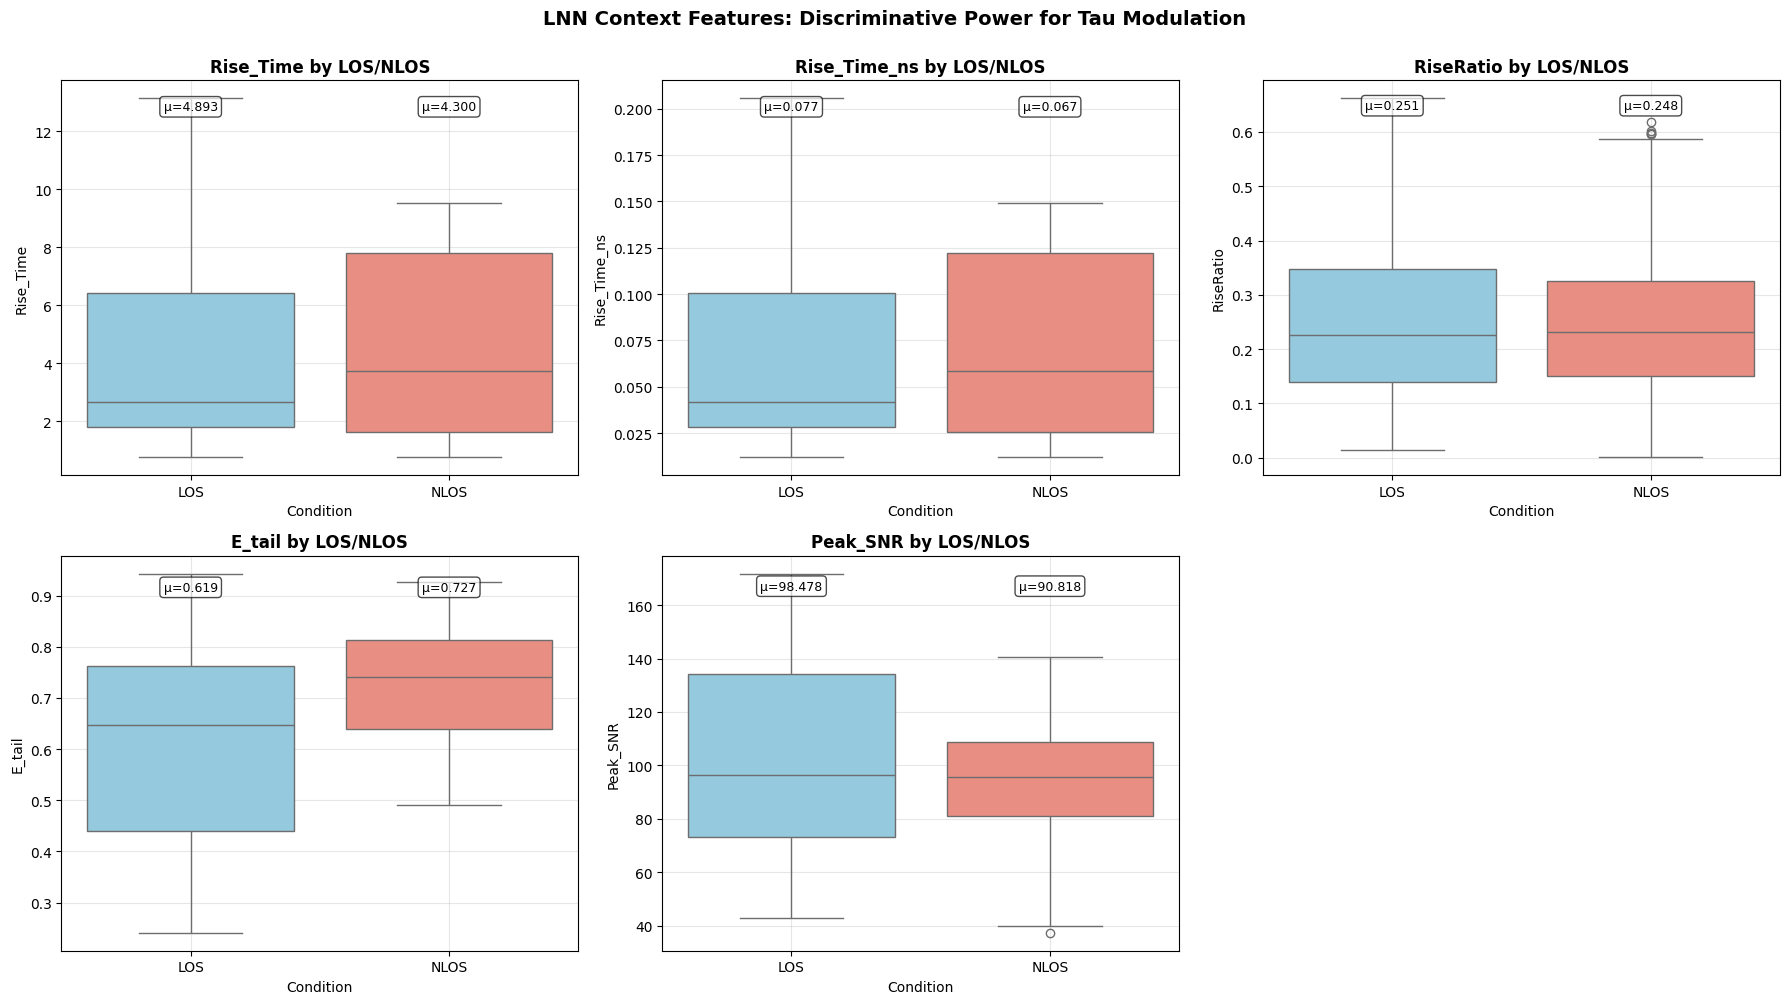


✅ These features will modulate the LNN's time constant (τ) to adapt to signal characteristics!


In [13]:
# Visualize LNN context features distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

lnn_features_plot = ['Rise_Time', 'Rise_Time_ns', 'RiseRatio', 'E_tail', 'Peak_SNR']

for idx, feat in enumerate(lnn_features_plot):
    ax = axes[idx]
    
    # Box plot
    sns.boxplot(data=data, x='label', y=feat, ax=ax, palette=['skyblue', 'salmon'])
    ax.set_title(f'{feat} by LOS/NLOS', fontsize=12, fontweight='bold')
    ax.set_xlabel('Condition', fontsize=10)
    ax.set_ylabel(feat, fontsize=10)
    ax.grid(alpha=0.3)
    
    # Add mean values as text
    los_mean = data[data['label'] == 'LOS'][feat].mean()
    nlos_mean = data[data['label'] == 'NLOS'][feat].mean()
    ax.text(0, ax.get_ylim()[1] * 0.95, f'μ={los_mean:.3f}', 
            ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.text(1, ax.get_ylim()[1] * 0.95, f'μ={nlos_mean:.3f}', 
            ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('LNN Context Features: Discriminative Power for Tau Modulation', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ These features will modulate the LNN's time constant (τ) to adapt to signal characteristics!")

Mean first-bounce delay (ns) by label:
           mean       std  count
label                           
LOS    0.127908  0.038360   4000
NLOS   0.122798  0.031781   4000

Multipath count by label:
           mean       std  count
label                           
LOS    12.33125  2.417847   4000
NLOS   23.15025  8.444110   4000

→ NLOS first bounce is -4.0% different from LOS
→ NLOS has +87.7% more multipath components than LOS


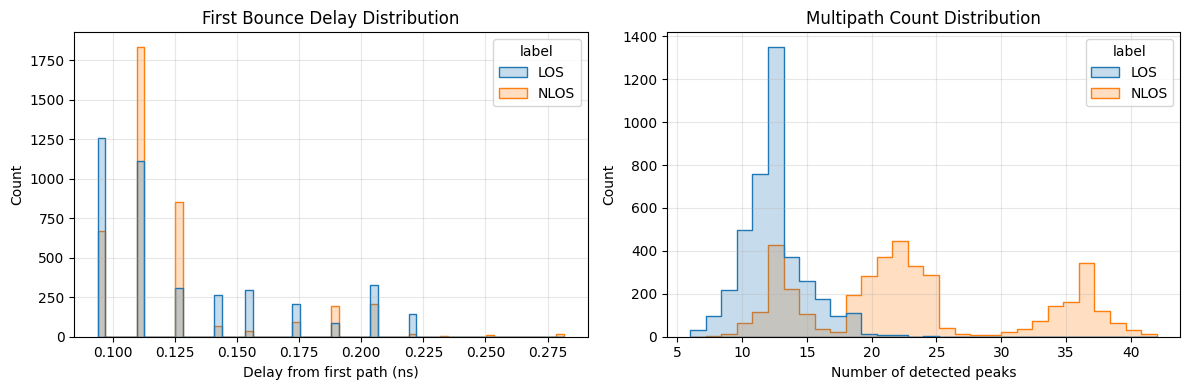

In [14]:
### 5.3 Multipath Characteristics by LOS/NLOS

print('Mean first-bounce delay (ns) by label:')
bounce_stats = data.groupby('label')['first_bounce_delay_ns'].agg(['mean', 'std', 'count'])
print(bounce_stats)

print('\nMultipath count by label:')
multipath_stats = data.groupby('label')['multipath_count'].agg(['mean', 'std', 'count'])
print(multipath_stats)

# Calculate percentage difference
los_bounce = data[data['label'] == 'LOS']['first_bounce_delay_ns'].mean()
nlos_bounce = data[data['label'] == 'NLOS']['first_bounce_delay_ns'].mean()
print(f'\n→ NLOS first bounce is {((nlos_bounce - los_bounce)/los_bounce * 100):+.1f}% different from LOS')

los_mp = data[data['label'] == 'LOS']['multipath_count'].mean()
nlos_mp = data[data['label'] == 'NLOS']['multipath_count'].mean()
print(f'→ NLOS has {((nlos_mp - los_mp)/los_mp * 100):+.1f}% more multipath components than LOS')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=data, x='first_bounce_delay_ns', hue='label', bins=60, element='step', kde=False)
plt.title('First Bounce Delay Distribution')
plt.xlabel('Delay from first path (ns)')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='multipath_count', hue='label', bins=30, element='step', kde=False)
plt.title('Multipath Count Distribution')
plt.xlabel('Number of detected peaks')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. CIR Waveform Visualization

Visualization window: CIR indices 740 to 790


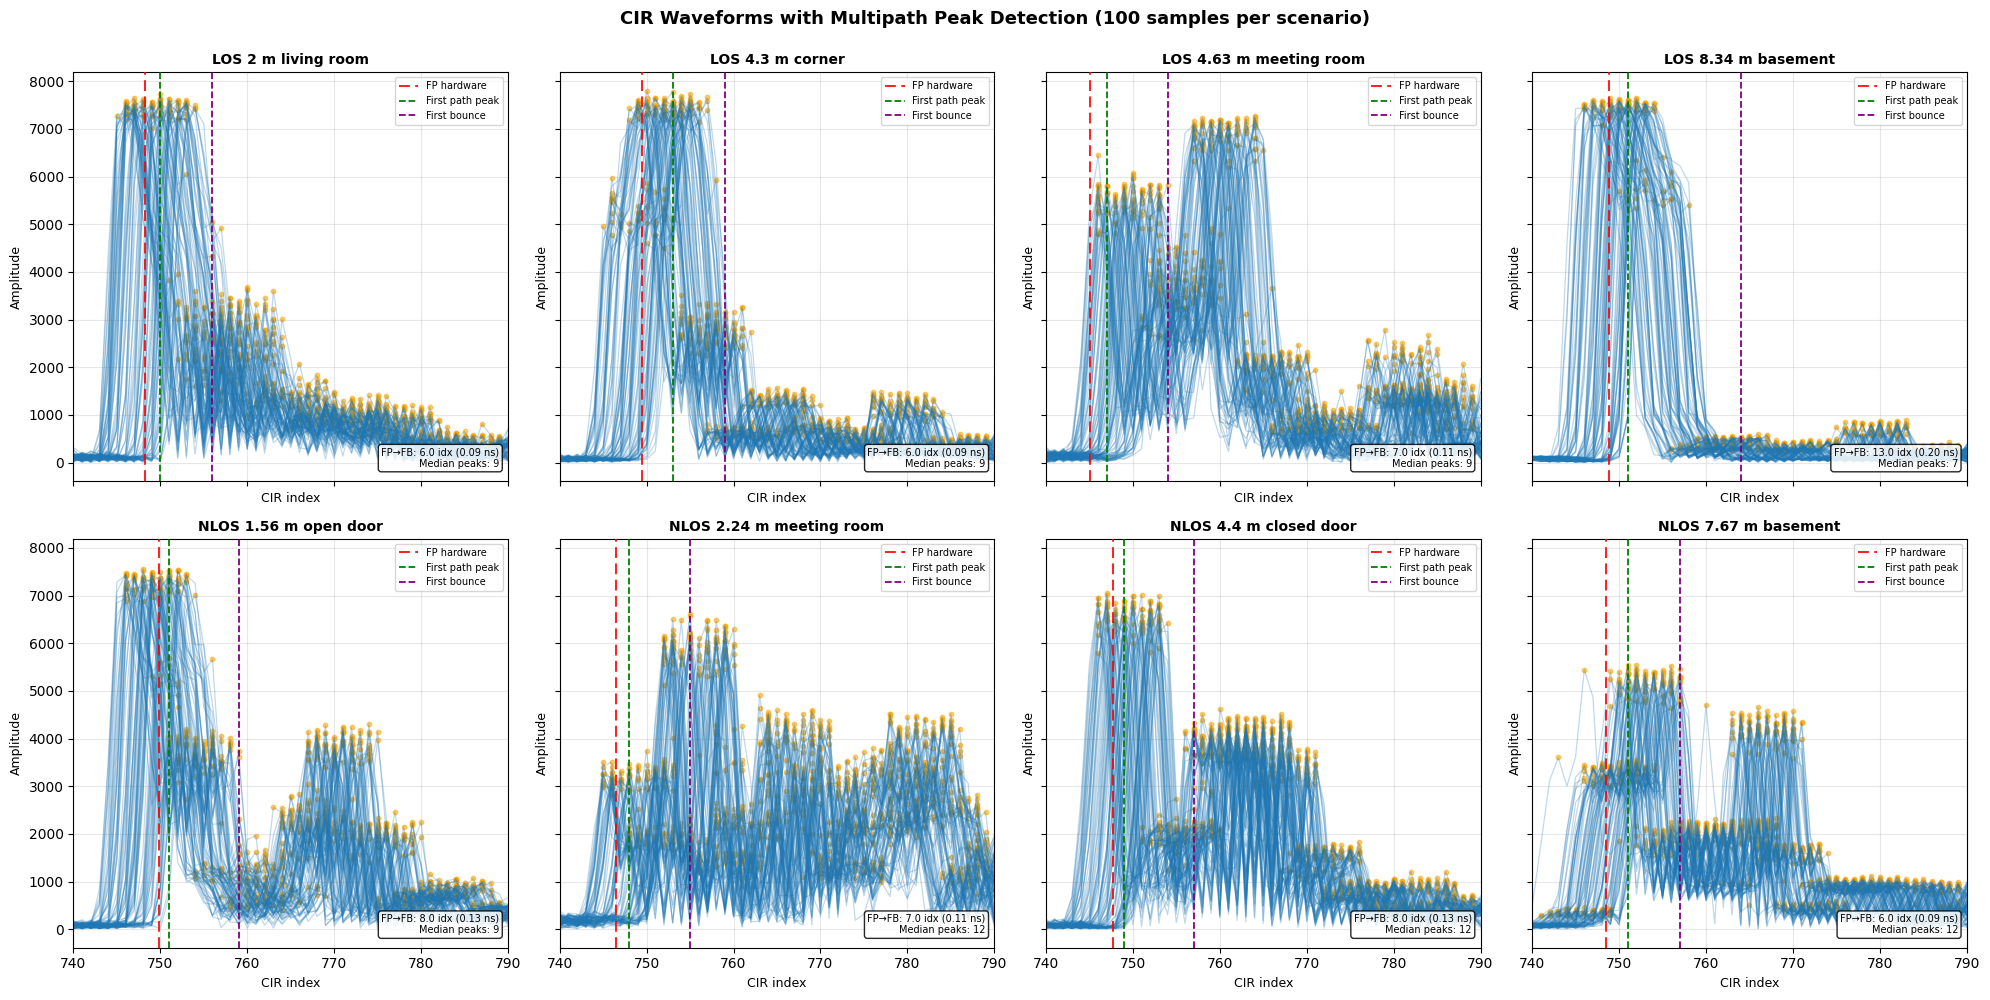

In [15]:
### 7.1 Sample CIR with Multipath Peak Detection

start, end = 740, 790
print(f"Visualization window: CIR indices {start} to {end}")

scenarios_all = list(data["scenario"].unique())
plot_scenarios = [s for s in PREFERRED_SCENARIOS if s in scenarios_all]
for s in scenarios_all:
    if s not in plot_scenarios:
        plot_scenarios.append(s)

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, scen in zip(axes, plot_scenarios[:8]):
    rows = data[data["scenario"] == scen].head(100)
    if rows.empty:
        ax.axis("off")
        continue
    first_row = rows.iloc[0]
    x = np.arange(start, end + 1)
    peak_counts = []
    
    for _, row in rows.iterrows():
        wf = row[cir_cols].values.astype(float)
        noise_floor = np.median(np.abs(wf[0:600]))
        threshold = noise_floor * 5
        peaks = simple_peaks(np.abs(wf[start:end + 1]), threshold=threshold, min_gap=2) + start
        peak_counts.append(len(peaks))
        ax.plot(x, wf[start:end + 1], color="#1f77b4", alpha=0.28, lw=0.9)
        ax.scatter(peaks, wf[peaks], color="orange", s=10, alpha=0.55)

    fp_hw = first_row.get("FP_INDEX", np.nan) / FP_INDEX_SCALE
    fp_peak_idx = first_row.get("fp_peak_idx", np.nan)
    fb_idx = first_row.get("first_bounce_idx", np.nan)
    
    handles, labels = [], []
    if not np.isnan(fp_hw):
        fp_line_x = fp_hw
        if not np.isnan(fp_peak_idx) and abs(fp_hw - fp_peak_idx) < 1.0:
            fp_line_x = fp_hw - 1.0
        h = ax.axvline(fp_line_x, color="red", ls=(0, (6, 3)), lw=1.3, alpha=0.95, zorder=7)
        handles.append(h); labels.append("FP hardware")
    if not np.isnan(fp_peak_idx):
        h = ax.axvline(fp_peak_idx, color="green", ls="--", lw=1.3, zorder=6)
        handles.append(h); labels.append("First path peak")
    if not np.isnan(fb_idx):
        h = ax.axvline(fb_idx, color="purple", ls="--", lw=1.3, zorder=6)
        handles.append(h); labels.append("First bounce")

    ax.set_xlim(start, end)
    ax.set_title(scen, fontsize=10, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_xlabel("CIR index", fontsize=9)
    ax.set_ylabel("Amplitude", fontsize=9)
    
    if handles:
        ax.legend(handles, labels, loc="upper right", fontsize=7)

    lines_text = []
    if not np.isnan(fp_peak_idx) and not np.isnan(fb_idx):
        gap_idx = fb_idx - fp_peak_idx
        gap_ns = gap_idx * TS_DW1000 * 1e9
        lines_text.append(f"FP→FB: {gap_idx:.1f} idx ({gap_ns:.2f} ns)")
    if peak_counts:
        lines_text.append(f"Median peaks: {np.median(peak_counts):.0f}")
    if lines_text:
        ax.text(0.98, 0.03, "\n".join(lines_text), fontsize=7,
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.85),
                va="bottom", ha="right", transform=ax.transAxes)

plt.suptitle("CIR Waveforms with Multipath Peak Detection (100 samples per scenario)", 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 7.2 Full CIR Waveform Comparison

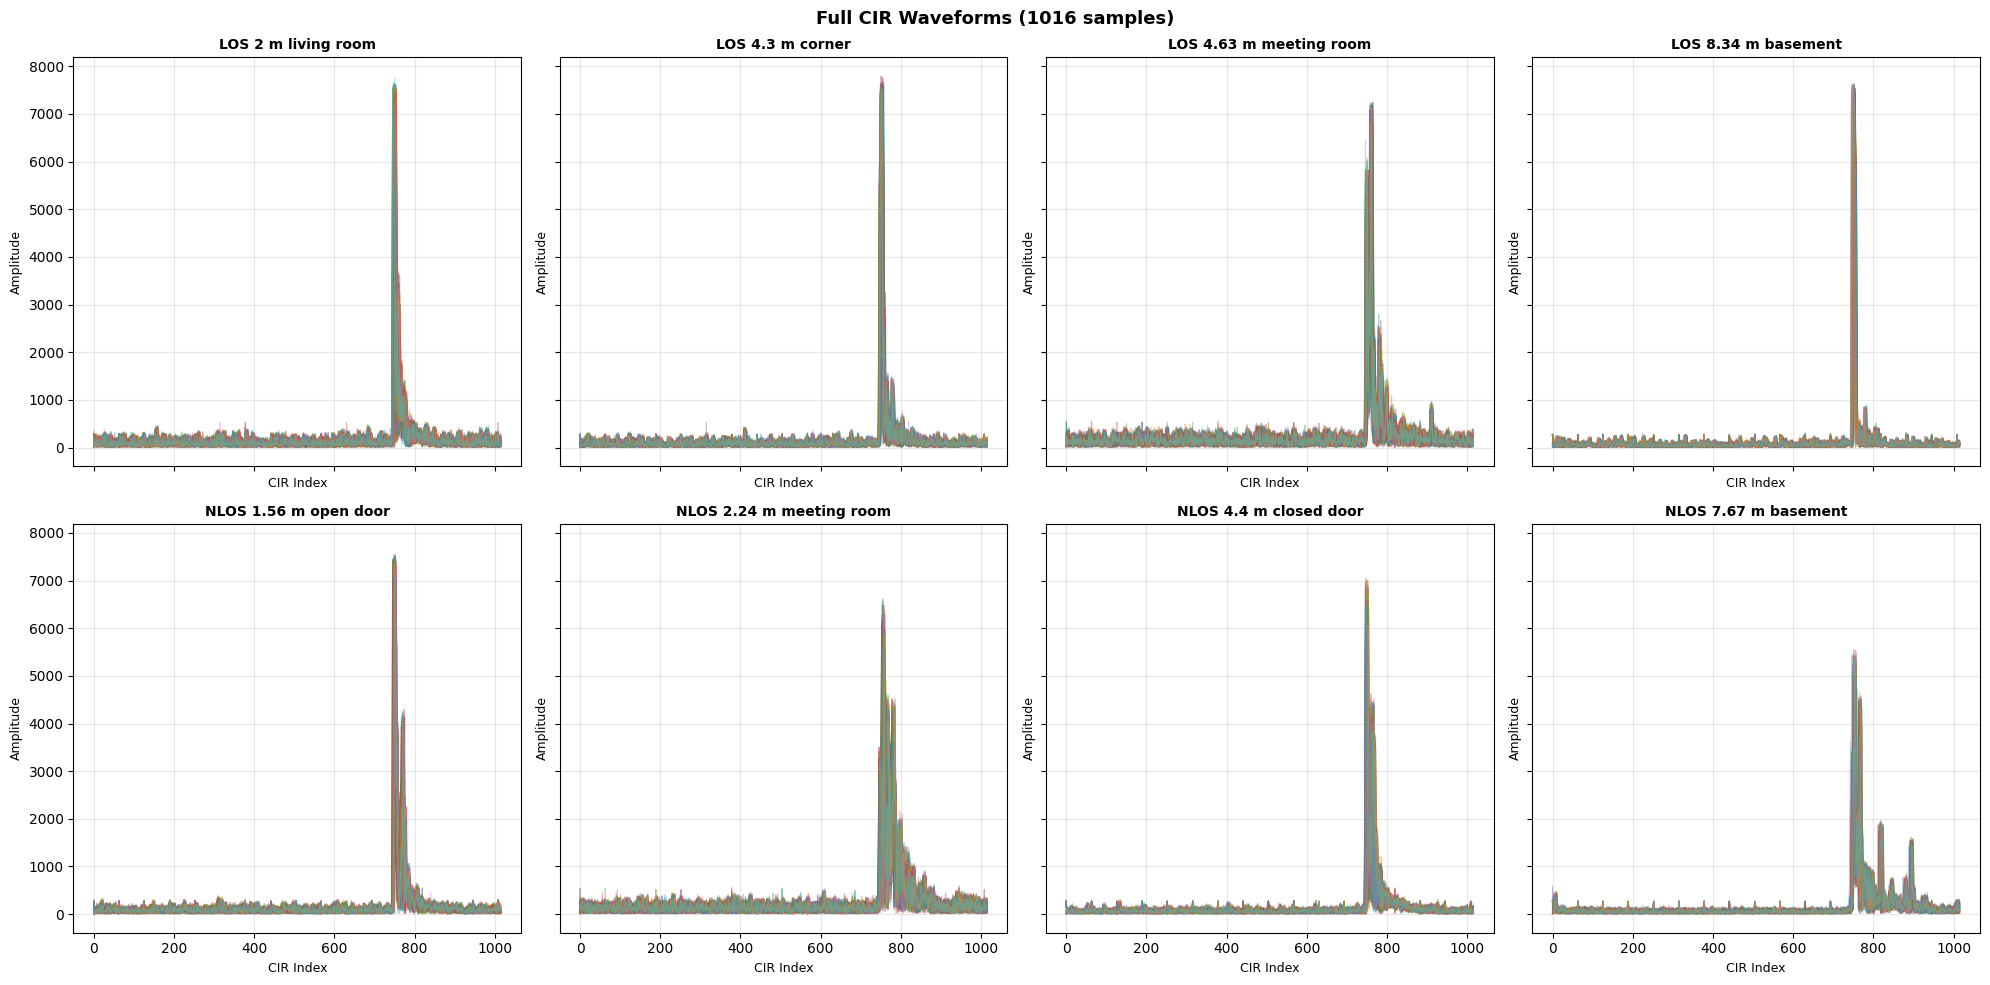

In [16]:
# Full CIR comparison (100 samples per scenario for clarity)
scenarios_all = list(data["scenario"].unique())
plot_scenarios = [s for s in PREFERRED_SCENARIOS if s in scenarios_all]
for s in scenarios_all:
    if s not in plot_scenarios:
        plot_scenarios.append(s)

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, scen in zip(axes, plot_scenarios[:8]):
    rows = data.loc[data["scenario"] == scen].head(100)
    if rows.empty:
        ax.axis('off')
        continue
    for _, row in rows.iterrows():
        wf = row[cir_cols].values.astype(float)
        x = np.arange(len(wf))
        ax.plot(x, wf, lw=0.8, alpha=0.35)
    ax.set_title(f"{scen}", fontsize=10, fontweight='bold')
    ax.set_xlabel("CIR Index", fontsize=9)
    ax.set_ylabel("Amplitude", fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle("Full CIR Waveforms (1016 samples)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.3 Signal Stability Analysis (Mean ± Std Dev)

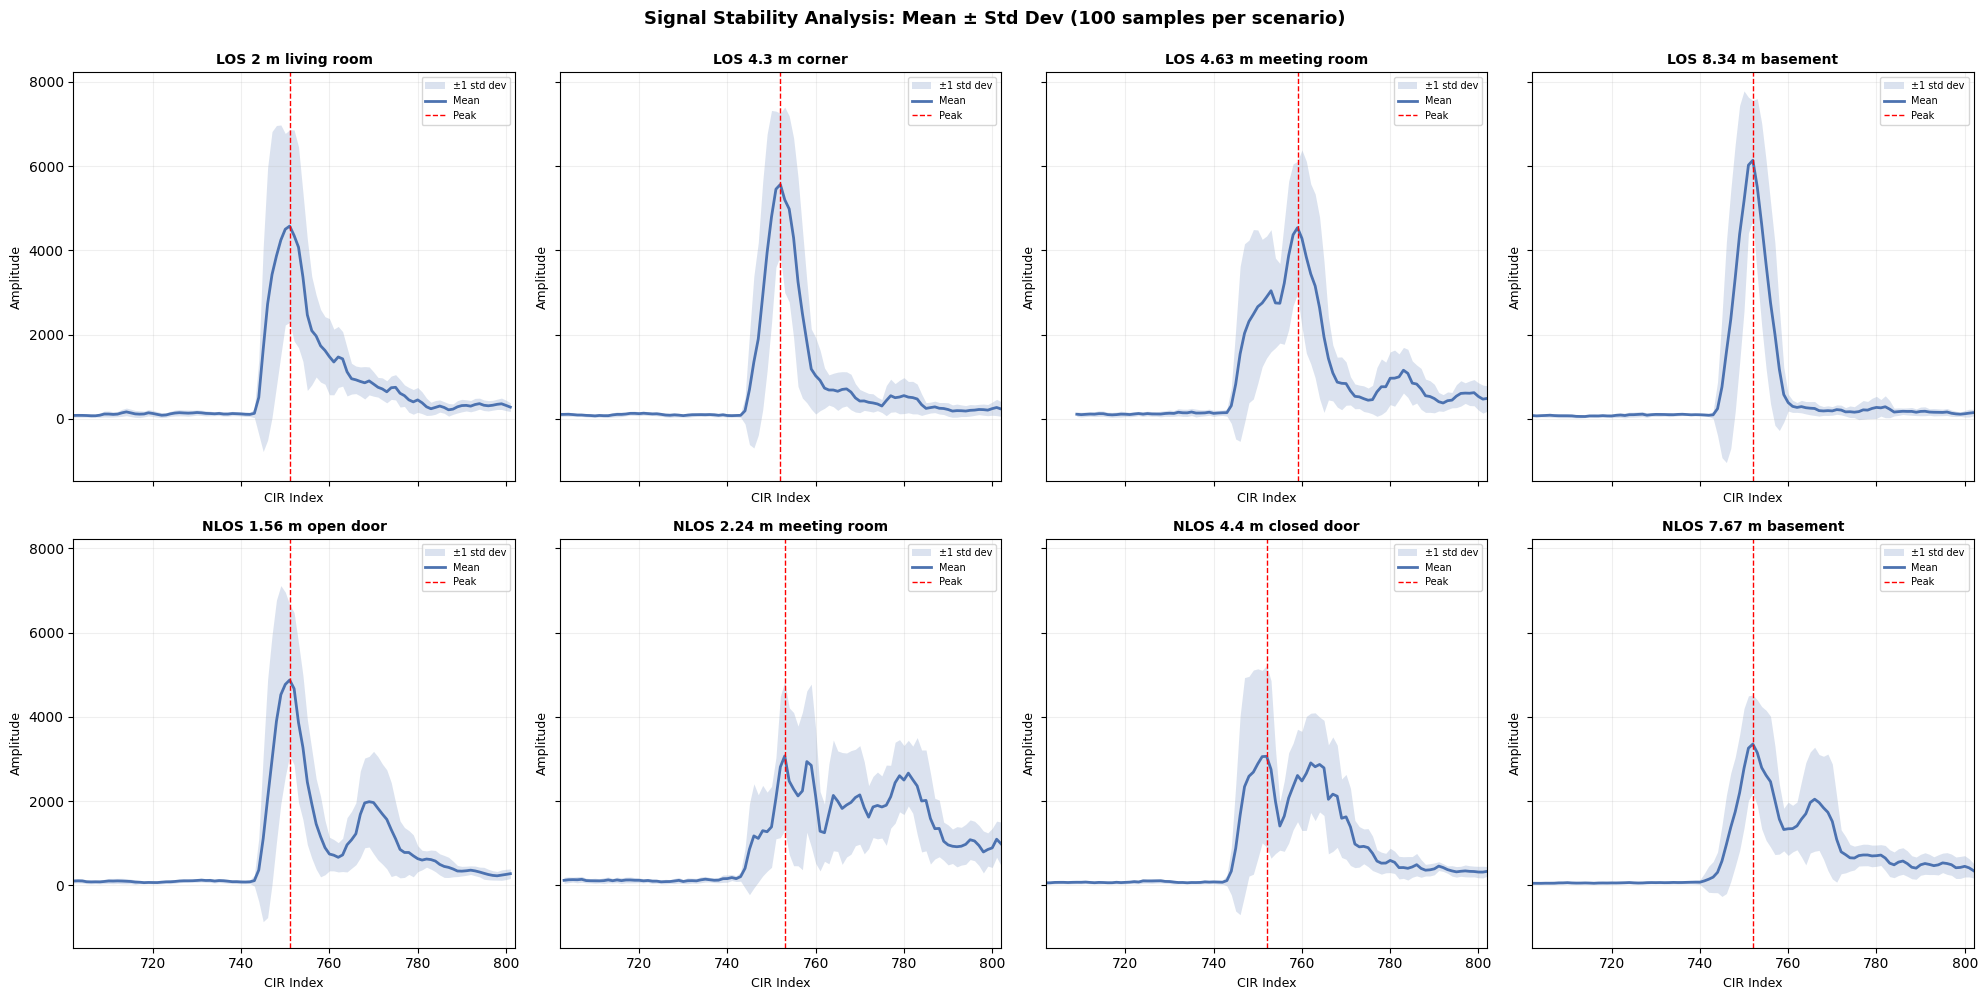


📊 Peak Characteristics by Scenario:
  LOS 2 m living room            | Peak @ index  751 | Amplitude  4576.0
  NLOS 1.56 m open door          | Peak @ index  751 | Amplitude  4876.3
  LOS 8.34 m basement            | Peak @ index  752 | Amplitude  6139.1
  LOS 4.3 m corner               | Peak @ index  752 | Amplitude  5564.9
  NLOS 7.67 m basement           | Peak @ index  752 | Amplitude  3354.1
  NLOS 4.4 m closed door         | Peak @ index  752 | Amplitude  3064.2
  NLOS 2.24 m meeting room       | Peak @ index  753 | Amplitude  3072.6
  LOS 4.63 m meeting room        | Peak @ index  759 | Amplitude  4537.0


In [17]:
# Signal stability: mean ± std dev around peak region
scenarios_all = list(data["scenario"].unique())
plot_scenarios = [s for s in PREFERRED_SCENARIOS if s in scenarios_all]
for s in scenarios_all:
    if s not in plot_scenarios:
        plot_scenarios.append(s)

results = []
zoom_half = 50  # ±50 samples around peak
color = sns.color_palette("deep")[0]

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, scen in zip(axes, plot_scenarios[:8]):
    rows = data.loc[data["scenario"] == scen].head(100)
    if rows.empty:
        ax.axis("off")
        continue
    wf_stack = rows[cir_cols].values.astype(float)
    mean_wf = wf_stack.mean(axis=0)
    std_wf = wf_stack.std(axis=0)
    x = np.arange(mean_wf.shape[0])
    peak_idx = int(np.argmax(mean_wf))
    peak_amp = float(mean_wf[peak_idx])
    results.append({"scenario": scen, "peak_idx": peak_idx, "peak_amp": peak_amp})

    # Zoom window
    z0 = max(0, peak_idx - zoom_half)
    z1 = min(len(x) - 1, peak_idx + zoom_half)
    lower = mean_wf - std_wf
    upper = mean_wf + std_wf

    ax.fill_between(x[z0:z1 + 1], lower[z0:z1 + 1], upper[z0:z1 + 1],
                    color=color, alpha=0.2, linewidth=0, label='±1 std dev')
    ax.plot(x[z0:z1 + 1], mean_wf[z0:z1 + 1], color=color, lw=2, label="Mean")
    ax.axvline(peak_idx, color="red", ls="--", lw=1, label="Peak")

    ax.set_xlim(z0, z1)
    ax.set_title(scen, fontsize=10, fontweight='bold')
    ax.set_xlabel("CIR Index", fontsize=9)
    ax.set_ylabel("Amplitude", fontsize=9)
    ax.grid(alpha=0.2)
    ax.legend(fontsize=7)

fig.suptitle("Signal Stability Analysis: Mean ± Std Dev (100 samples per scenario)", 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n📊 Peak Characteristics by Scenario:")
print("=" * 70)
peak_df = pd.DataFrame(results).sort_values("peak_idx")
for _, row in peak_df.iterrows():
    print(f"  {row['scenario']:30s} | Peak @ index {row['peak_idx']:4d} | Amplitude {row['peak_amp']:7.1f}")
print("=" * 70)

## 8. Baseline LOS/NLOS Classification

Simple logistic regression model to validate that LOS/NLOS classification is feasible.

**Features used:** `roi_energy`, `fp_peak_amp`, `first_bounce_delay_ns`, `multipath_count`, `FP_INDEX_scaled`, `Max_Index`

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

feat_cols = ['roi_energy', 'fp_peak_amp', 'first_bounce_delay_ns', 'multipath_count', 'FP_INDEX_scaled', 'Max_Index']
df = data.dropna(subset=feat_cols).copy()
X = df[feat_cols].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('=' * 80)
print('BASELINE LOGISTIC REGRESSION CLASSIFIER')
print('=' * 80)
print(f'\nTraining samples: {len(X_train):,}')
print(f'Test samples: {len(X_test):,}')
print(f'\n🎯 Overall Accuracy: {accuracy_score(y_test, y_pred):.3f} ({accuracy_score(y_test, y_pred)*100:.1f}%)')

print('\n📊 Confusion Matrix (rows=actual, cols=predicted):')
cm = confusion_matrix(y_test, y_pred)
print(f'\n              Predicted LOS    Predicted NLOS')
print(f'Actual LOS    {cm[0,0]:8d}         {cm[0,1]:8d}')
print(f'Actual NLOS   {cm[1,0]:8d}         {cm[1,1]:8d}')

print('\n📋 Classification Report:')
print(classification_report(y_test, y_pred, digits=3))

print('🔍 Feature Importance (coefficient magnitude):')
print('-' * 80)
coef = clf.named_steps['logisticregression'].coef_[0]
feat_importance = sorted(zip(feat_cols, coef), key=lambda t: abs(t[1]), reverse=True)
for rank, (name, c) in enumerate(feat_importance, 1):
    direction = "→ NLOS" if c > 0 else "→ LOS"
    print(f"{rank}. {name:25s}: {c:+7.3f}  {direction}")
print('=' * 80)

BASELINE LOGISTIC REGRESSION CLASSIFIER

Training samples: 6,400
Test samples: 1,600

🎯 Overall Accuracy: 0.927 (92.7%)

📊 Confusion Matrix (rows=actual, cols=predicted):

              Predicted LOS    Predicted NLOS
Actual LOS         757               43
Actual NLOS         74              726

📋 Classification Report:
              precision    recall  f1-score   support

         LOS      0.911     0.946     0.928       800
        NLOS      0.944     0.907     0.925       800

    accuracy                          0.927      1600
   macro avg      0.928     0.927     0.927      1600
weighted avg      0.928     0.927     0.927      1600

🔍 Feature Importance (coefficient magnitude):
--------------------------------------------------------------------------------
1. Max_Index                :  -6.198  → LOS
2. fp_peak_amp              :  -5.548  → LOS
3. roi_energy               :  -3.472  → LOS
4. FP_INDEX_scaled          :  +3.426  → NLOS
5. multipath_count          :  +3.030  → 

## 9. Dataset Summary & Export

In [19]:
print("=" * 90)
print("COMPREHENSIVE DATASET SUMMARY")
print("=" * 90)

# Overall statistics
print(f"\n📊 TOTAL DATASET: {len(data):,} samples")
print(f"   LOS:  {len(data[data['label']=='LOS']):,} samples ({len(data[data['label']=='LOS'])/len(data)*100:.1f}%)")
print(f"   NLOS: {len(data[data['label']=='NLOS']):,} samples ({len(data[data['label']=='NLOS'])/len(data)*100:.1f}%)")

print("\n" + "-" * 90)
print("📍 ENVIRONMENT BREAKDOWN")
print("-" * 90)

# Group by environment
data['environment'] = data['scenario'].apply(lambda x: 
    'Home' if 'living room' in x or 'door' in x 
    else 'Meeting Room' if 'meeting room' in x 
    else 'Basement')

for env in ['Home', 'Meeting Room', 'Basement']:
    env_data = data[data['environment'] == env]
    if len(env_data) == 0:
        continue
    print(f"\n{env}:")
    print(f"  Total: {len(env_data):,} samples")
    print(f"  LOS:   {len(env_data[env_data['label']=='LOS']):,} samples")
    print(f"  NLOS:  {len(env_data[env_data['label']=='NLOS']):,} samples")
    print(f"  Distance range: {env_data['d_true'].min():.2f}m - {env_data['d_true'].max():.2f}m")

print("\n" + "-" * 90)
print("📋 SCENARIO DETAILS")
print("-" * 90)

scenario_stats = []
for scen in PREFERRED_SCENARIOS:
    if scen not in data['scenario'].values:
        continue
    subset = data[data['scenario'] == scen]
    scenario_stats.append({
        'Scenario': scen,
        'Samples': len(subset),
        'Label': subset['label'].iloc[0],
        'Distance (m)': subset['d_true'].iloc[0],
        'Avg d_error (m)': subset['d_error'].mean(),
        'Error %': (subset['d_error'].mean() / subset['d_true'].iloc[0] * 100)
    })

scenario_df = pd.DataFrame(scenario_stats)
print(scenario_df.to_string(index=False))

print("\n" + "=" * 90)
print("✅ READY FOR TRIPLE-OUTPUT LNN TRAINING")
print("=" * 90)
print("\nKey columns for model:")
print("  • CIR0-CIR1015: Raw Channel Impulse Response (1016 samples)")
print("  • Context features: t_start, t_peak, Rise_Time_ns, RiseRatio, E_tail, Peak_SNR, multipath_count")
print("  • Classification target: label (LOS/NLOS)")
print("  • Regression targets: d_single_bounce, d_error")
print("  • Derived: d_true = d_single_bounce - d_error")
print("=" * 90)

COMPREHENSIVE DATASET SUMMARY

📊 TOTAL DATASET: 8,000 samples
   LOS:  4,000 samples (50.0%)
   NLOS: 4,000 samples (50.0%)

------------------------------------------------------------------------------------------
📍 ENVIRONMENT BREAKDOWN
------------------------------------------------------------------------------------------

Home:
  Total: 3,000 samples
  LOS:   1,000 samples
  NLOS:  2,000 samples
  Distance range: 1.56m - 4.40m

Meeting Room:
  Total: 2,000 samples
  LOS:   1,000 samples
  NLOS:  1,000 samples
  Distance range: 2.24m - 4.63m

Basement:
  Total: 3,000 samples
  LOS:   2,000 samples
  NLOS:  1,000 samples
  Distance range: 4.30m - 8.34m

------------------------------------------------------------------------------------------
📋 SCENARIO DETAILS
------------------------------------------------------------------------------------------
                Scenario  Samples Label  Distance (m)  Avg d_error (m)    Error %
     LOS 2 m living room     1000   LOS          

### 9.1 Export Enhanced Dataset with All Features

In [20]:
# Export complete dataset with all features
output_path = Path('../dataset/merged_cir_enhanced.csv')
data.to_csv(output_path, index=False)

print(f"✅ Saved enhanced dataset to: {output_path}")
print(f"   Total samples: {len(data):,}")
print(f"   Total columns: {len(data.columns)}")
print(f"\nNew features added:")
print("   • d_single_bounce: Hardware-based distance estimation")
print("   • d_error: Ranging error (NLOS bias)")
print("   • environment: Categorical grouping (Home/Meeting Room/Basement)")
print("   • All LNN context features: t_start, t_peak, Rise_Time, RiseRatio, E_tail, Peak_SNR")
print("   • Multipath features: fp_peak_idx, first_bounce_idx, first_bounce_delay_ns, multipath_count")
print("\n🚀 Ready for Multi-Scale LNN triple-output training!")

✅ Saved enhanced dataset to: ..\dataset\merged_cir_enhanced.csv
   Total samples: 8,000
   Total columns: 1051

New features added:
   • d_single_bounce: Hardware-based distance estimation
   • d_error: Ranging error (NLOS bias)
   • environment: Categorical grouping (Home/Meeting Room/Basement)
   • All LNN context features: t_start, t_peak, Rise_Time, RiseRatio, E_tail, Peak_SNR
   • Multipath features: fp_peak_idx, first_bounce_idx, first_bounce_delay_ns, multipath_count

🚀 Ready for Multi-Scale LNN triple-output training!


### 9.2 Create Merged Dataset (All 8 CSVs Combined)

In [21]:
# Create merged_cir.csv for quick loading in future runs
merged_output_path = Path('../dataset/merged_cir.csv')

# Save the basic merged dataset (just the raw data, before feature engineering)
# This will be used at the start of the notebook to skip individual CSV loading
merged_basic = []
for fname, label, d_true, scen in files:
    df = pd.read_csv(fname)
    df['label'] = label
    df['d_true'] = d_true
    df['scenario'] = scen
    merged_basic.append(df)

merged_basic_data = pd.concat(merged_basic, ignore_index=True)
merged_basic_data.to_csv(merged_output_path, index=False)

print(f"✅ Created merged dataset: {merged_output_path}")
print(f"   Total samples: {len(merged_basic_data):,}")
print(f"   Total columns: {len(merged_basic_data.columns)}")
print(f"   File size: {merged_output_path.stat().st_size / (1024*1024):.2f} MB")
print("\n💡 Next time, the notebook will load this file directly instead of 8 separate CSVs!")

✅ Created merged dataset: ..\dataset\merged_cir.csv
   Total samples: 8,000
   Total columns: 1028
   File size: 27.21 MB

💡 Next time, the notebook will load this file directly instead of 8 separate CSVs!


## 10. Merged Dataset EDA

Quick analysis of the merged dataset to verify data integrity.

In [22]:
### 10.1 Verify Merged Dataset Integrity

# Load the merged dataset we just created
merged_verify = pd.read_csv(merged_output_path)

print("=" * 90)
print("MERGED DATASET VERIFICATION")
print("=" * 90)
print(f"\n📊 Shape: {merged_verify.shape[0]:,} samples × {merged_verify.shape[1]} columns")

print("\n📋 Label Distribution:")
for label, count in merged_verify['label'].value_counts().items():
    print(f"  {label}: {count:,} samples ({count/len(merged_verify)*100:.1f}%)")

print("\n📍 Scenario Distribution:")
for scenario, count in merged_verify['scenario'].value_counts().items():
    print(f"  {scenario}: {count:,} samples")

print("\n✅ Data Integrity Check:")
print(f"  Missing values: {merged_verify.isna().sum().sum()}")
print(f"  Duplicate rows: {merged_verify.duplicated().sum()}")

print("\n📏 Distance Statistics:")
dist_stats = merged_verify.groupby('scenario')['d_true'].first().describe()
print(f"  Min distance: {dist_stats['min']:.2f}m")
print(f"  Max distance: {dist_stats['max']:.2f}m")
print(f"  Mean distance: {dist_stats['mean']:.2f}m")

print("\n" + "=" * 90)
merged_verify.head()

MERGED DATASET VERIFICATION

📊 Shape: 8,000 samples × 1028 columns

📋 Label Distribution:
  LOS: 4,000 samples (50.0%)
  NLOS: 4,000 samples (50.0%)

📍 Scenario Distribution:
  LOS 2 m living room: 1,000 samples
  LOS 4.3 m corner: 1,000 samples
  NLOS 1.56 m open door: 1,000 samples
  NLOS 4.4 m closed door: 1,000 samples
  LOS 4.63 m meeting room: 1,000 samples
  NLOS 2.24 m meeting room: 1,000 samples
  LOS 8.34 m basement: 1,000 samples
  NLOS 7.67 m basement: 1,000 samples

✅ Data Integrity Check:
  Missing values: 0
  Duplicate rows: 0

📏 Distance Statistics:
  Min distance: 1.56m
  Max distance: 8.34m
  Mean distance: 4.39m



,Capture_ID,Distance,FP_INDEX,FP_AMPL1,FP_AMPL2,FP_AMPL3,RXPACC,STD_NOISE,MAX_NOISE,CIR0,...,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,label,d_true,scenario
0,0,1.951188,47887,6794,7577,7081,118,64,1635,271,...,47,128,66,47,17,140,35,LOS,2.0,LOS 2 m living room
1,1,1.876143,48066,6564,7433,7098,118,60,1476,230,...,239,90,132,35,125,42,49,LOS,2.0,LOS 2 m living room
2,2,1.894904,47840,7071,7552,6047,118,48,1191,281,...,72,75,96,70,147,50,66,LOS,2.0,LOS 2 m living room
3,3,1.932427,47634,7102,7397,6927,118,56,1371,105,...,184,130,79,94,43,82,93,LOS,2.0,LOS 2 m living room
4,4,1.969950,47690,6727,7539,7420,118,56,1392,260,...,24,248,25,96,166,85,103,LOS,2.0,LOS 2 m living room


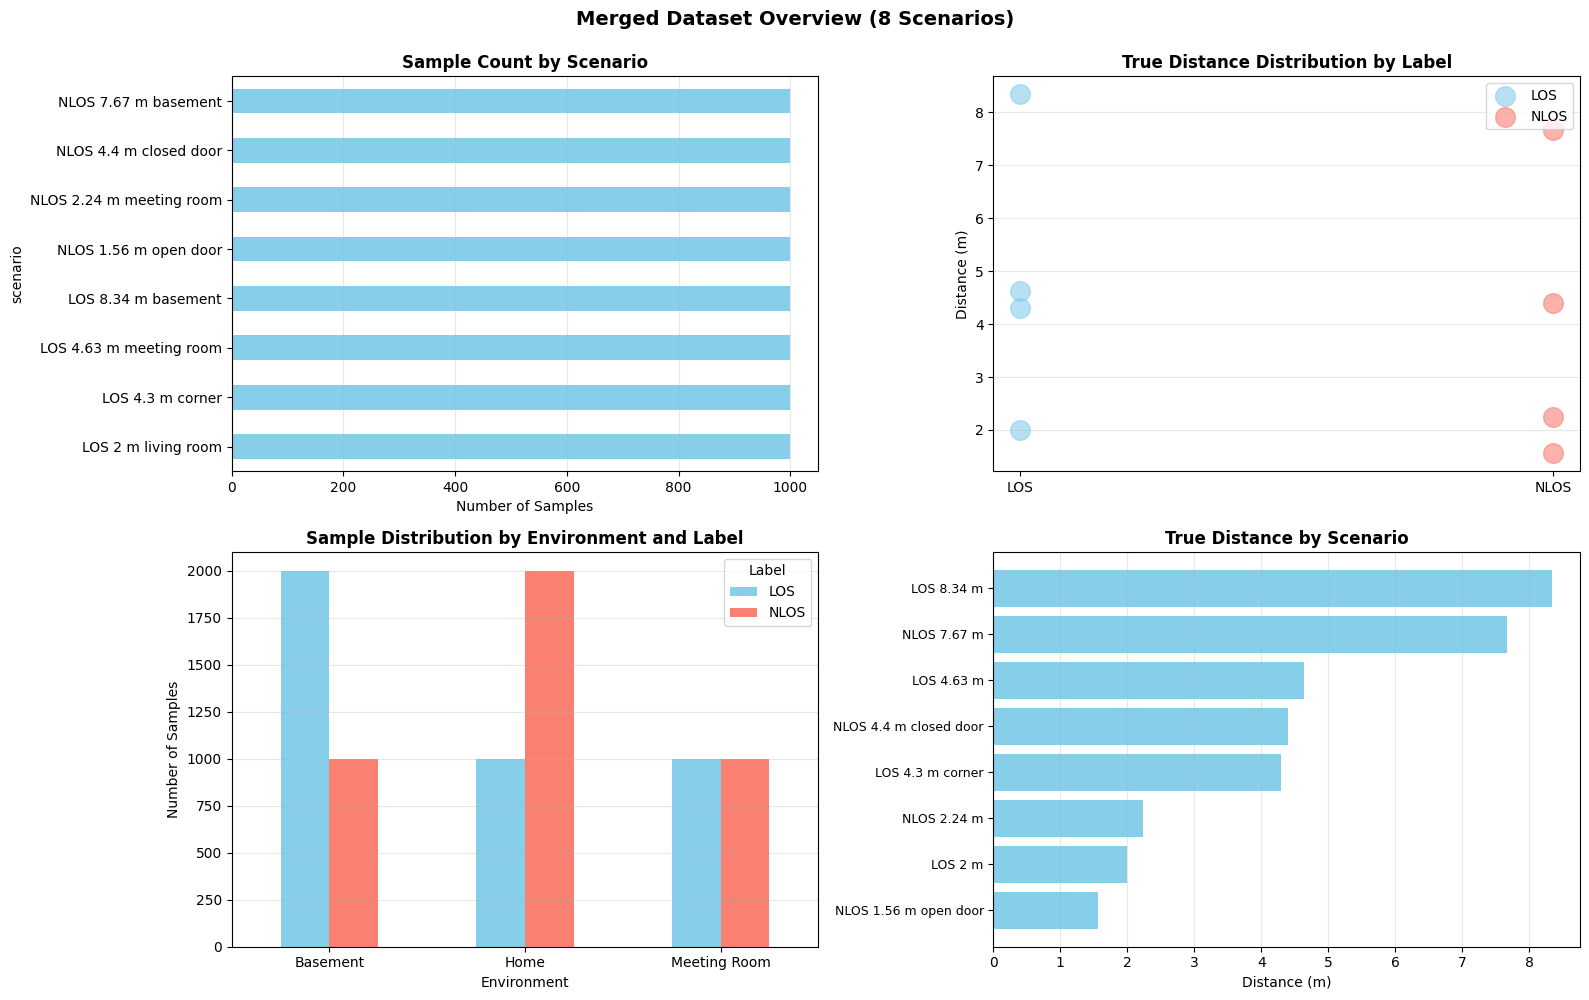


✅ Merged dataset visualization complete!


In [23]:
### 10.2 Merged Dataset: Scenario Comparison

# Visual comparison of all scenarios in the merged dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Sample count by scenario
ax1 = axes[0, 0]
scenario_counts = merged_verify['scenario'].value_counts().sort_index()
colors = ['skyblue' if 'LOS' in s else 'salmon' for s in scenario_counts.index]
scenario_counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_title('Sample Count by Scenario', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Samples')
ax1.grid(axis='x', alpha=0.3)

# 2. Distance distribution by label
ax2 = axes[0, 1]
for label in ['LOS', 'NLOS']:
    subset = merged_verify[merged_verify['label'] == label]
    distances = subset.groupby('scenario')['d_true'].first()
    ax2.scatter([label] * len(distances), distances, s=200, alpha=0.6, 
                label=label, color='skyblue' if label == 'LOS' else 'salmon')
ax2.set_title('True Distance Distribution by Label', fontsize=12, fontweight='bold')
ax2.set_ylabel('Distance (m)')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

# 3. Environment breakdown
ax3 = axes[1, 0]
merged_verify['environment'] = merged_verify['scenario'].apply(lambda x: 
    'Home' if 'living room' in x or 'door' in x 
    else 'Meeting Room' if 'meeting room' in x 
    else 'Basement')
env_label_counts = merged_verify.groupby(['environment', 'label']).size().unstack(fill_value=0)
env_label_counts.plot(kind='bar', ax=ax3, color=['skyblue', 'salmon'], stacked=False)
ax3.set_title('Sample Distribution by Environment and Label', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Samples')
ax3.set_xlabel('Environment')
ax3.legend(title='Label')
ax3.grid(axis='y', alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# 4. Distance range visualization
ax4 = axes[1, 1]
distances_by_scenario = merged_verify.groupby('scenario')['d_true'].first().sort_values()
scenarios_sorted = distances_by_scenario.index
colors_sorted = ['skyblue' if 'LOS' in s else 'salmon' for s in scenarios_sorted]
ax4.barh(range(len(scenarios_sorted)), distances_by_scenario.values, color=colors_sorted)
ax4.set_yticks(range(len(scenarios_sorted)))
ax4.set_yticklabels([s.replace(' living room', '').replace(' meeting room', '').replace(' basement', '') 
                      for s in scenarios_sorted], fontsize=9)
ax4.set_title('True Distance by Scenario', fontsize=12, fontweight='bold')
ax4.set_xlabel('Distance (m)')
ax4.grid(axis='x', alpha=0.3)

plt.suptitle('Merged Dataset Overview (8 Scenarios)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Merged dataset visualization complete!")

In [24]:
### 10.3 Merged Dataset: Summary Statistics Table

print("=" * 110)
print("COMPREHENSIVE MERGED DATASET SUMMARY")
print("=" * 110)

summary_data = []
for scen in PREFERRED_SCENARIOS:
    if scen in merged_verify['scenario'].values:
        subset = merged_verify[merged_verify['scenario'] == scen]
        summary_data.append({
            'Scenario': scen,
            'Label': subset['label'].iloc[0],
            'Samples': len(subset),
            'Distance (m)': subset['d_true'].iloc[0],
            'Environment': subset['environment'].iloc[0]
        })

summary_df = pd.DataFrame(summary_data)

print("\nScenario Details:")
print(summary_df.to_string(index=False))

print(f"\n\nOverall Statistics:")
print(f"  Total Samples: {len(merged_verify):,}")
print(f"  Total Scenarios: {merged_verify['scenario'].nunique()}")
print(f"  LOS Scenarios: {len(merged_verify[merged_verify['label']=='LOS']['scenario'].unique())}")
print(f"  NLOS Scenarios: {len(merged_verify[merged_verify['label']=='NLOS']['scenario'].unique())}")
print(f"  Environments: {merged_verify['environment'].nunique()} (Home, Meeting Room, Basement)")
print(f"  Distance Range: {merged_verify['d_true'].min():.2f}m - {merged_verify['d_true'].max():.2f}m")

print("\n" + "=" * 110)
print("✅ MERGED DATASET READY FOR ANALYSIS")
print("   File: ../dataset/merged_cir.csv")
print("   Enhanced File: ../dataset/merged_cir_enhanced.csv (with all engineered features)")
print("=" * 110)

COMPREHENSIVE MERGED DATASET SUMMARY

Scenario Details:
                Scenario Label  Samples  Distance (m)  Environment
     LOS 2 m living room   LOS     1000          2.00         Home
        LOS 4.3 m corner   LOS     1000          4.30     Basement
 LOS 4.63 m meeting room   LOS     1000          4.63 Meeting Room
     LOS 8.34 m basement   LOS     1000          8.34     Basement
   NLOS 1.56 m open door  NLOS     1000          1.56         Home
NLOS 2.24 m meeting room  NLOS     1000          2.24 Meeting Room
  NLOS 4.4 m closed door  NLOS     1000          4.40         Home
    NLOS 7.67 m basement  NLOS     1000          7.67     Basement


Overall Statistics:
  Total Samples: 8,000
  Total Scenarios: 8
  LOS Scenarios: 4
  NLOS Scenarios: 4
  Environments: 3 (Home, Meeting Room, Basement)
  Distance Range: 1.56m - 8.34m

✅ MERGED DATASET READY FOR ANALYSIS
   File: ../dataset/merged_cir.csv
   Enhanced File: ../dataset/merged_cir_enhanced.csv (with all engineered features)